In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/fabio1079/MLOpsTools/main/mlopstools/csvdata/2021-05-10.csv", sep=";")

In [4]:
df.head()

,gspread_row,use_area,tool_name,repo_owner,repo_name,main_branch,total_commits,last_commit_check,fork_count,stars_count,watchers_count,license_name,primary_language,is_archived,open_issues,closed_issues
0,2,AutoML,AutoGluon,awslabs,autogluon,master,600,False,413,3212,82,Apache License 2.0,Python,False,89,346
1,3,AutoML,AutoKeras,keras-team,autokeras,master,1251,False,1282,7941,301,Apache License 2.0,Python,False,67,669
2,4,AutoML,AutoPyTorch,automl,Auto-PyTorch,master,127,False,150,1218,43,Apache License 2.0,Python,False,52,68
3,5,AutoML,AutoSKLearn,automl,auto-sklearn,master,2457,False,1017,5403,220,Other,Python,False,96,612
4,6,AutoML,MLBox,AxeldeRomblay,MLBox,master,1121,True,254,1221,67,Other,Python,False,13,73


In [5]:
def rank_tool(archived: bool, commit_check: bool, open_license:bool, open_issues:int, closed_issues:int, watchers:int, stars:int, forks:int, commits:int):
  if archived or commit_check:
    return 0.0

  #if not open_license:
  #  return 0.0

  total_issues = open_issues + closed_issues
  issue_rank = closed_issues / total_issues if total_issues > 0 else 0.0

  calc = watchers*1.3 + stars*1.2 + forks*1.1 + issue_rank *1.0 + commits*0.9
  calc = calc / (1.3 + 1.2 + 1.1 + 1.0 + 0.9)

  return calc

In [6]:
ranks = []
for index, row in df.iterrows():
  rank = rank_tool(
      row['is_archived'],
      row['last_commit_check'],
      row['license_name'] != 'Other',
      row['open_issues'],
      row['closed_issues'],
      row['watchers_count'],
      row['stars_count'],
      row['fork_count'],
      row['total_commits'])
  ranks.append(rank)

In [7]:
df = df.assign(rank=ranks)

In [8]:
disqualified = df.loc[df['rank'] == 0]
qualified = df.loc[df['rank'] > 0]

In [9]:
print("Total qualified")
print(len(qualified))
print("Total disqualified")
print(len(disqualified))

Total qualified
72
Total disqualified
6


In [10]:
disqualified.loc[disqualified['total_commits'] > 500]

,gspread_row,use_area,tool_name,repo_owner,repo_name,main_branch,total_commits,last_commit_check,fork_count,stars_count,watchers_count,license_name,primary_language,is_archived,open_issues,closed_issues,rank
4,6,AutoML,MLBox,AxeldeRomblay,MLBox,master,1121,True,254,1221,67,Other,Python,False,13,73,0.0
6,8,Cron Job Monitoring,minicron,jamesrwhite,minicron,master,1249,True,165,2344,83,GNU General Public License v3.0,Ruby,False,44,190,0.0
45,53,Model Serving,PredictionIO,apache,attic-predictionio,develop,4495,True,2021,12508,773,Apache License 2.0,Scala,True,0,0,0.0


In [11]:
qualified.describe()

,gspread_row,total_commits,fork_count,stars_count,watchers_count,open_issues,closed_issues,rank
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,46.069444,3583.055556,1407.208333,6340.611111,223.777778,246.986111,822.208333,2304.184485
std,26.004510,5525.693226,3124.876029,7158.111572,327.189536,398.930595,1280.734989,2854.435941
min,2.000000,66.000000,0.000000,20.000000,1.000000,0.000000,0.000000,20.327273
25%,23.500000,728.750000,207.500000,1350.000000,48.750000,43.250000,82.000000,565.119494
50%,46.500000,1603.500000,471.500000,3788.500000,122.500000,96.000000,424.500000,1242.391467
75%,69.250000,4015.250000,1407.750000,8255.750000,269.750000,263.250000,852.750000,2804.578928
max,88.000000,30011.000000,23817.000000,38442.000000,2109.000000,2086.000000,6788.000000,16633.800000


In [12]:
use_areas = qualified['use_area'].unique()

In [13]:
tools_by_use_area = { k: [] for k in use_areas }

In [14]:
for area in tools_by_use_area.keys():
  tools_by_use_area[area] = qualified.loc[qualified['use_area'] == area]

In [15]:
for area in tools_by_use_area.keys():
  tools_by_use_area[area] = tools_by_use_area[area].sort_values(by=['rank'], ascending=False)

# Top 5 by area

In [16]:
top_5_by_area = {}
for area in tools_by_use_area.keys():
  top_5_by_area[area] = tools_by_use_area[area].head(5)

In [17]:
def plot_area(area, use_area):
  labels = area['tool_name']
  values = area['rank']

  fig, ax = plt.subplots()
  ax.barh(labels, values, align='center')
  ax.set_xlabel("Rank")
  ax.set_title(use_area)

  plt.show()

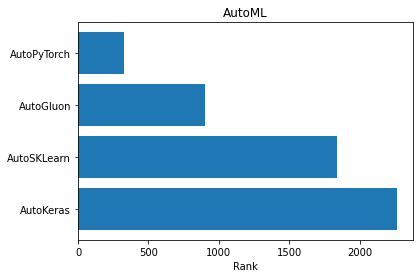

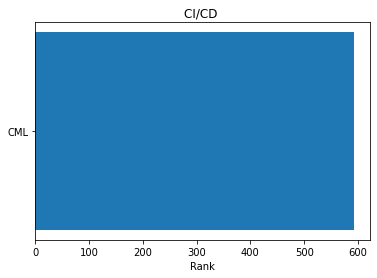

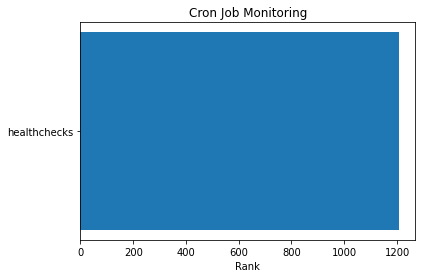

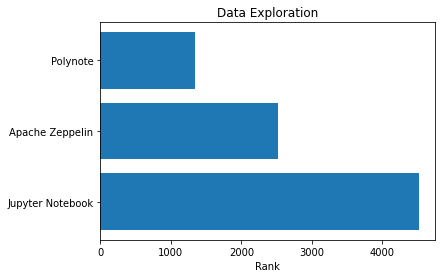

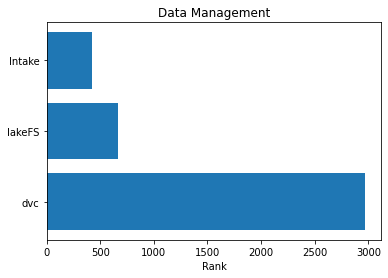

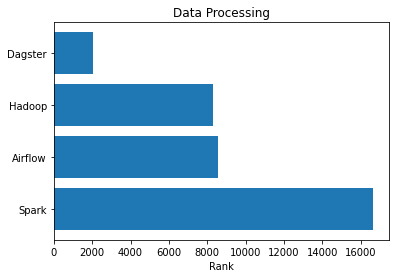

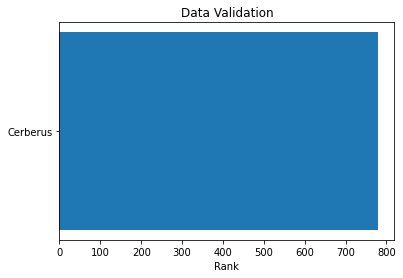

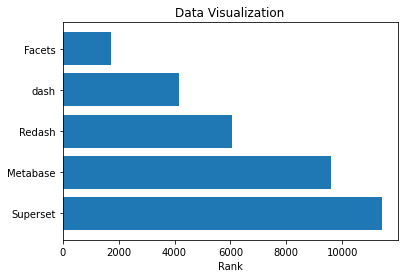

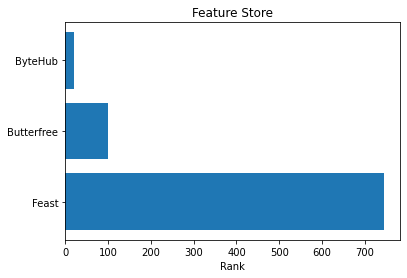

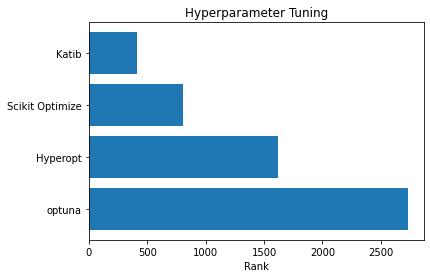

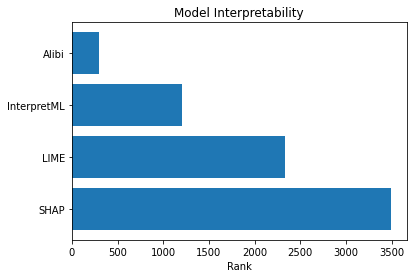

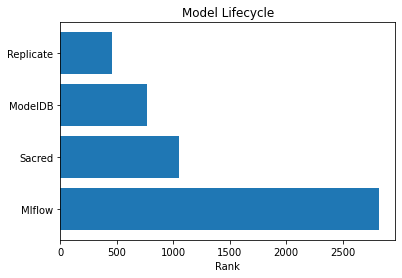

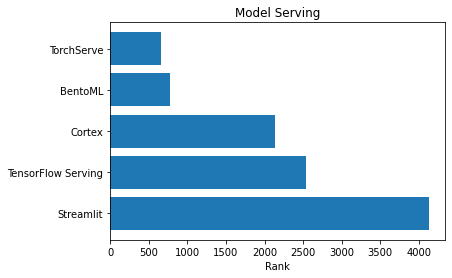

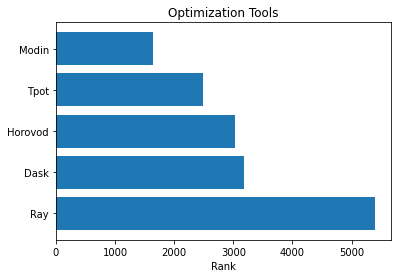

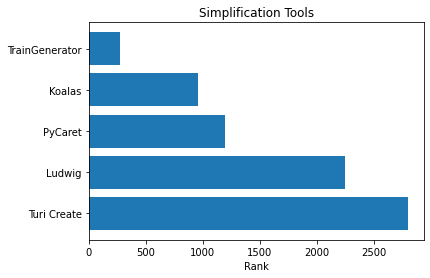

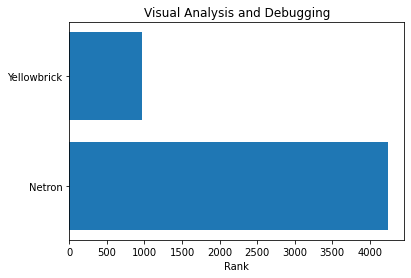

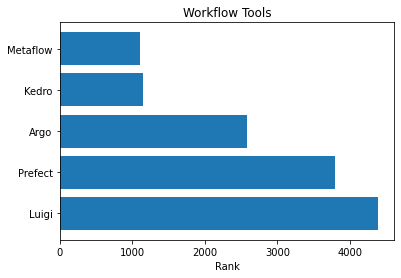

In [18]:
for area in top_5_by_area:
  plot_area(top_5_by_area[area], area)